# DC2: Matching DIA vs Truth lightcurves
<br> Author: **Bruno Sanchez** [bruno.sanchez@duke.edu]
<br> Last verified to run: **10-15-2019**

## What this notebook does
- This notebook performs a coordinate match between the `diaObject` catalog and the DC2 `truth variable summary` catalog, both accessible through GCR catalog tool. To do this we are using `astropy.coordinates.Skycoord` object, making possible to match both catalogs at once.  

- After that we ask for the lightcurves of each element of each catalog, and perform a _time match_. This is done by requiring that the MJD difference between the DIA and Truth cat is less than 5 minutes. 

- Finally we calculate some metrics on the objects recovered.

## Some more detail

### Time for processing

The time for processing is quite long, and you can actually skip the long cell that performs the individual time-matching for each epoch and load the table itself from the `.csv` file already generated

### Catalogs used

We used the following catalogs
* diaSrc => `dc2_dia_source_run1.2p_test`
* diaObject => `dc2_dia_object_run1.2p_test`
* truth_cat => `dc2_truth_run1.2_variable_summary`
* truth_lc => `dc2_truth_run1.2_variable_lightcurve`

In [1]:
# Inject gcr-catalogs that supports DIA source into path.
import os
import math
import sys

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
# Requires issues/337 to fix obshistid query.
sys.path.insert(0, '/global/homes/b/bos0109/desc/gcr-catalogs')

In [3]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
from lsst.daf.persistence import Butler
from lsst.geom import SpherePoint
import lsst.geom

In [4]:
import GCRCatalogs

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [6]:
repo = '/global/cscratch1/sd/rearmstr/new_templates/diffim_template'

In [7]:
butler = Butler(repo)

In [139]:
diaSrc = GCRCatalogs.load_catalog('dc2_dia_source_run1.2p_test')
diaObject = GCRCatalogs.load_catalog('dc2_dia_object_run1.2p_test')
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')
truth_lc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/GCR/base.py:373: UserWarning: Native quantity `psFluxMean_u` does not exist (required by `magMean_u`, `magMeanStd_u`, `psFluxMean_u`)
  warnings.warn(msg)


In [140]:
truth_cat.list_all_quantities(include_native=True)

['agn', 'sn', 'sprinkled', 'ra', 'redshift', 'uniqueId', 'galaxy_id', 'dec']

How many objects are there in truth cat?

In [141]:
len(truth_cat)

406450

In [142]:
all_qtys = ['galaxy_id', 'redshift', 'ra', 
            'sprinkled', 'sn', 'agn', 'dec', 'uniqueId']

In [143]:
truth_cat = pd.DataFrame(truth_cat.get_quantities(all_qtys))

Here we split the catalog into AGN sources and SNe, we will be working with SNe only.

In [144]:
all_sn = truth_cat[truth_cat.sn==True]

In [145]:
all_agn = truth_cat[truth_cat.agn==True]

In [146]:
print('''We have a total of {} SNe, {} AGNs and they add up to {}'''.format(
    len(all_sn), len(all_agn), len(all_sn)+len(all_agn)))

We have a total of 76689 SNe, 329761 AGNs and they add up to 406450


Fine, we have everything splitted in two.  
We may have to filter to get only tract 4849 and patch (6, 6) objects.

In [147]:
tract = 4849
patch = (6, 6)

skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[tract]

foo = tract_info.getPatchInfo(patch)

bar = foo.getOuterSkyPolygon(tract_info.getWcs())

In [148]:
# he uses lsst.afwGeom Box2D to parse the tract bounding box into lsst's stack language
tract_box = afwGeom.Box2D(tract_info.getBBox())

tract_box

Box2D(minimum=Point2D(-0.5, -0.5), dimensions=Extent2D(28000, 28000))

In [149]:
tract_pos_list = tract_box.getCorners()

tract_pos_list

[Point2D(-0.5, -0.5),
 Point2D(27999.5, -0.5),
 Point2D(27999.5, 27999.5),
 Point2D(-0.5, 27999.5)]

In [151]:
tract_patch_box = tract_info.getPatchInfo(patch).getOuterBBox()
tract_patch_pos_list = tract_patch_box.getCorners()
# Cast to Point2D, because pixelToSky below will refuse to work with a Point2I object.
tract_patch_pos_list = [afwGeom.Point2D(tp) for tp in tract_patch_pos_list]

wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_patch_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [152]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [153]:
print(min_ra, max_ra)
print(min_dec, max_dec)

52.94720870249731 53.20754076704181
-28.456794947349533 -28.227701163624584


Now we can filter the SNe catalog to be inside this coordinate box by using pandas filtering

In [154]:
ff = (all_sn.ra > min_ra) & (all_sn.ra < max_ra) & \
     (all_sn.dec > min_dec) & (all_sn.dec < max_dec)

In [155]:
all_sn = all_sn[ff]

In [156]:
ff = (all_agn.ra > min_ra) & (all_agn.ra < max_ra) & \
     (all_agn.dec > min_dec) & (all_agn.dec < max_dec)

In [157]:
len(all_sn)

216

In [158]:
all_agn = all_agn[ff]

Now lets obtain their lightcurves. First we need the info on this light curve catalogs.

In [159]:
diaSrc.get_catalog_info()

{'subclass_name': 'dc2_dia_source.DC2DiaSourceCatalog',
 'base_dir': '/global/projecta/projectdirs/lsst/production/DC2_PhoSim/Run1.2p/dpdd/dia_source_catalog_test',
 'schema_filename': 'schema.yaml',
 'filename_pattern': 'dia_src_visit_\\d+\\.parquet$',
 'description': 'DC2 Run 1.2p DIA Source Catalog test patch',
 'creators': ['Michael Wood-Vasey']}

In [160]:
diaObject.get_catalog_info()

{'subclass_name': 'dc2_dia_object.DC2DiaObjectCatalog',
 'base_dir': '/global/projecta/projectdirs/lsst/production/DC2_PhoSim/Run1.2p/dpdd/dia_object_catalog_test',
 'schema_filename': 'schema.yaml',
 'filename_pattern': 'dia_object_tract_\\d+\\.parquet$',
 'description': 'DC2 Run 1.2p DIA Object Catalog test patch',
 'creators': ['Michael Wood-Vasey']}

In [161]:
#diaSrc.list_all_quantities(include_native=True)

In [162]:
qq = diaObject.list_all_quantities(include_native=False)

In [163]:
quants = []
for acol in qq:
    try:
        diaObject.get_quantities(acol)
        quants.append(acol)
    except:
        print(acol)

psFluxMean_u
magMean_u
magMeanErr_u
clean
magMeanErr_g
psFluxChi2_u
magMeanStd_u
magMeanErr_i
magMeanErr_r
psFluxMeanErr_u
good
magMeanErr_z
psFluxNdata_u
magMeanErr_y
psFluxSigma_u


/global/homes/b/bos0109/desc/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [164]:
diaOcols = ['ra', 'dec', 'diaObjectId', 'psFluxSigma_r', 'psFluxMean_r', 'psFluxMeanErr_r']
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
diaObject_cat = pd.DataFrame(diaObject.get_quantities(quants))

In [165]:
diaObject_cat.columns

Index(['psFluxSigma_z', 'psFluxSigma_y', 'magMeanStd_y', 'diaObjectId',
       'psFluxNdata_y', 'psFluxMean_r', 'magMean_r', 'psFluxMeanErr_g',
       'psFluxChi2_g', 'dec', 'psFluxMean_i', 'magMeanStd_z', 'magMean_i',
       'psFluxMeanErr_y', 'psFluxChi2_y', 'magMeanStd_i', 'ra',
       'psFluxMeanErr_r', 'magMeanStd_r', 'magMean_z', 'psFluxMean_g',
       'psFluxMean_y', 'magMeanStd_g', 'psFluxNdata_i', 'psFluxMeanErr_z',
       'magMean_y', 'magMean_g', 'psFluxNdata_r', 'psFluxChi2_i',
       'psFluxNdata_z', 'psFluxNdata_g', 'psFluxSigma_i', 'psFluxChi2_r',
       'psFluxMeanErr_i', 'psFluxSigma_r', 'psFluxChi2_z', 'psFluxSigma_g',
       'psFluxMean_z'],
      dtype='object')

The cell above was meant to filter the list of DIA Objects so we throw away bogus detections.   
In the end, we just keep them, and can always filter them in the future.

In [166]:
diaObject_positions = SkyCoord(diaObject_cat['ra'], diaObject_cat['dec'], unit='deg')

In [167]:
all_sn_positions = SkyCoord(all_sn['ra'], all_sn['dec'], unit='deg')

Now we are building the arrays for astropy coordinate match to be feasible.  
In any case, we perform the matching in both directions and keep the ones that had mutual agreement.

In [168]:
idx, d2d, d3d = all_sn_positions.match_to_catalog_sky(diaObject_positions)

In [169]:
idx_, d2d_, d3d_ = diaObject_positions.match_to_catalog_sky(all_sn_positions)

This is the example of how to validate this two direction cross match:

In [170]:
idx_[idx[0]]

0

In [173]:
d2d.to(u.arcsec)[0]

<Angle 0.02883608 arcsec>

Now we do it for the whole sample

In [171]:
match = np.repeat(False, len(idx))
matchO = np.repeat(False, len(idx_))
not_matched = []
for i in range(len(idx)):
    if i==idx_[idx[i]]:
        match[i] = True
        matchO[idx[i]] = True
    else:
        not_matched.append([i, idx[i], idx_[idx[i]]])
        

In [172]:
np.sum(match), np.sum(matchO)

(182, 182)

Here we have a histogram of the match distances

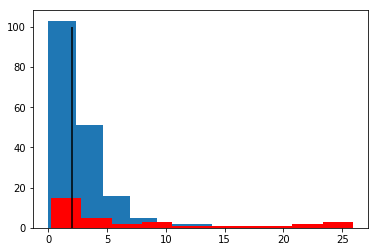

In [174]:
plt.hist(d2d[match].to(u.arcsec).value, log=False)
plt.hist(d2d[~match].to(u.arcsec).value, log=False, color='red')
plt.vlines(x=2., ymin=0, ymax=100)
plt.xlabel(r'Distance of match $\Delta$ [arcsec]')
plt.ylabel('N')

In [175]:
match.shape

(216,)

In [176]:
all_sn_positions.shape

(216,)

In [177]:
not_matched = np.array(not_matched)

Adding this information to the SNe catalog

In [178]:
all_sn['matched'] = match
all_sn['match_ang_dist'] = d2d.to(u.arcsec)
all_sn['dia_row'] = idx

In [179]:
print(matchO.shape, len(diaObject_cat))

(18864,) 18864


Adding the equivalent information to the DIA Object catalog

In [180]:
diaObject_cat['match'] = matchO
diaObject_cat['sn_row'] = idx_
diaObject_cat['match_ang_dist'] = d2d_.to(u.arcsec)

No we can see the angular distance calculated by the matching routine.   

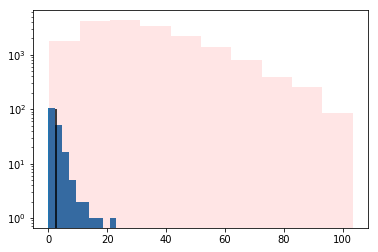

In [182]:
plt.hist(d2d_[matchO].to(u.arcsec).value, log=True, label='SN to DIA')
plt.hist(d2d_[~matchO].to(u.arcsec).value, log=False, color='red', alpha=0.1, label='DIA to SN')
plt.vlines(x=2.5, ymin=0, ymax=100)
#plt.xscale('log')
plt.xlabel(r'Angular Distance $\Delta [arcsec]')
plt.ylabel('N')
plt.legend(loc='upper right')

Now we make a sky chart plot of the positions of the DIA and SN in the sky.  
Blue is the SNe catalog, red are the DIA objects.

In the right panel we have the matched DIA objects. We see that we have much less density of objects.

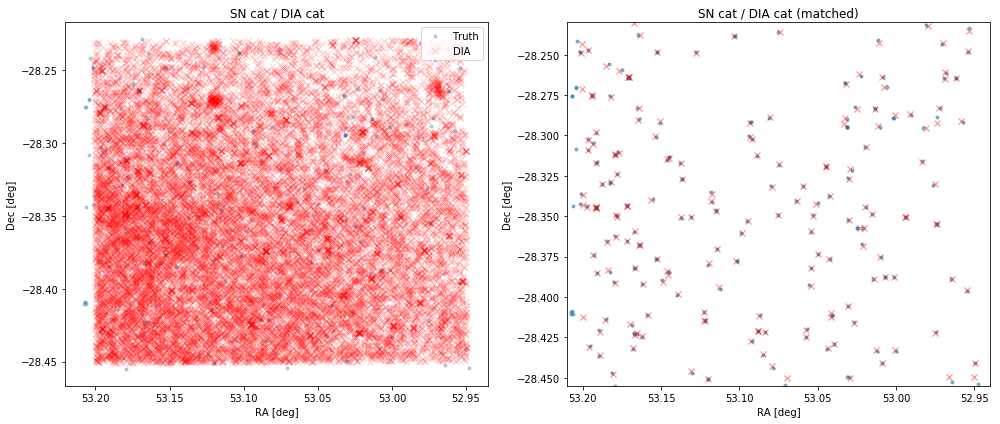

In [183]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title('SN cat / DIA cat')
plt.plot(all_sn.ra, all_sn.dec, '.', alpha=0.3, label='Truth')
plt.plot(diaObject_cat.ra, diaObject_cat.dec, 'rx', alpha=0.2, label='DIA')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.legend(loc='best')
plt.gca().invert_xaxis()


plt.subplot(122)
plt.title('SN cat / DIA cat (matched)')
plt.plot(all_sn.ra, all_sn.dec, '.', alpha=0.5, label='Truth')
plt.plot(diaObject_cat[matchO].ra, diaObject_cat[matchO].dec, 'rx', alpha=0.5, label='DIA')
plt.xlim(52.94, 53.21)
plt.ylim(-28.455, -28.23)
plt.gca().invert_xaxis()
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

In [184]:
diaObject_cat.to_csv('diaObject_matched.csv')
all_sn.to_csv('all_sn_matched.csv')

Now we have two tables, with the corresponding rows matched. 

We could find useful to have everything in the same table, so we are going to build a unified catalog of matched and orphan objects.

In [185]:
diaObject_cat['sn_Uid'] = None
diaObject_cat['sn_galaxy_id'] = None
diaObject_cat['sn_ra'] = None
diaObject_cat['sn_dec'] = None
diaObject_cat['sn_redshift'] = None
diaObject_cat['sn_sprinkled'] = None
diaObject_cat['sn_matched'] = None
diaObject_cat['sn_match_ang_dist'] = None
diaObject_cat['sn_dia_row'] = None

In [186]:
for i_row, arow in diaObject_cat.loc[diaObject_cat['match']].iterrows():
    allsnrow = all_sn.iloc[arow['sn_row']]
    if allsnrow['matched']:
        if allsnrow['dia_row']==i_row:
            
            diaObject_cat.loc[i_row, 'sn_Uid'] = allsnrow['uniqueId']
            diaObject_cat.loc[i_row, 'sn_galaxy_id'] = allsnrow['galaxy_id']
            diaObject_cat.loc[i_row, 'sn_ra'] = allsnrow['ra']
            diaObject_cat.loc[i_row, 'sn_dec'] = allsnrow['dec']
            diaObject_cat.loc[i_row, 'sn_redshift'] = allsnrow['redshift']
            diaObject_cat.loc[i_row, 'sn_sprinkled'] = allsnrow['sprinkled']
            diaObject_cat.loc[i_row, 'sn_matched'] = True
            diaObject_cat.loc[i_row, 'sn_msn_match_ang_distatch_ang_dist'] = allsnrow['match_ang_dist']
            diaObject_cat.loc[i_row, 'sn_dia_row'] = allsnrow['dia_row']


In [187]:
diaObject_cat.columns

Index(['psFluxSigma_z', 'psFluxSigma_y', 'magMeanStd_y', 'diaObjectId',
       'psFluxNdata_y', 'psFluxMean_r', 'magMean_r', 'psFluxMeanErr_g',
       'psFluxChi2_g', 'dec', 'psFluxMean_i', 'magMeanStd_z', 'magMean_i',
       'psFluxMeanErr_y', 'psFluxChi2_y', 'magMeanStd_i', 'ra',
       'psFluxMeanErr_r', 'magMeanStd_r', 'magMean_z', 'psFluxMean_g',
       'psFluxMean_y', 'magMeanStd_g', 'psFluxNdata_i', 'psFluxMeanErr_z',
       'magMean_y', 'magMean_g', 'psFluxNdata_r', 'psFluxChi2_i',
       'psFluxNdata_z', 'psFluxNdata_g', 'psFluxSigma_i', 'psFluxChi2_r',
       'psFluxMeanErr_i', 'psFluxSigma_r', 'psFluxChi2_z', 'psFluxSigma_g',
       'psFluxMean_z', 'match', 'sn_row', 'match_ang_dist', 'sn_Uid',
       'sn_galaxy_id', 'sn_ra', 'sn_dec', 'sn_redshift', 'sn_sprinkled',
       'sn_matched', 'sn_match_ang_dist', 'sn_dia_row',
       'sn_msn_match_ang_distatch_ang_dist'],
      dtype='object')

In [188]:
translate = {'sprinkled': "sn_sprinkled", 
             'ra': "sn_ra", 
             'dec': "sn_dec",
             'redshift': "sn_redshift", 
             'uniqueId': "sn_Uid", 
             'galaxy_id': "sn_galaxy_id",
             'matched': "sn_matched", 
             'match_ang_dist': "sn_match_ang_dist",
             'dia_row': "sn_dia_row"}

tr_cols = ['sprinkled', 'ra', 'redshift', 'uniqueId', 
           'galaxy_id', 'dec', 'matched', 'match_ang_dist', 'dia_row']

appendable = all_sn[tr_cols].copy()
appendable.rename(columns=translate, inplace=True)

In [257]:
fullcat = diaObject_cat.append(appendable[appendable['sn_matched']==False])

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [258]:
diaObject_cat.head()

,psFluxSigma_z,psFluxSigma_y,magMeanStd_y,diaObjectId,psFluxNdata_y,psFluxMean_r,magMean_r,psFluxMeanErr_g,psFluxChi2_g,dec,...,sn_Uid,sn_galaxy_id,sn_ra,sn_dec,sn_redshift,sn_sprinkled,sn_matched,sn_match_ang_dist,sn_dia_row,sn_msn_match_ang_distatch_ang_dist
0,1205.094874,1198.593153,0.291921,21326977935867905,42.0,3199.611629,22.637257,198.836984,13145.890139,-28.427916,...,None,None,None,None,None,None,None,None,None,NaN
1,NaN,NaN,NaN,21326977935867906,NaN,1117.920220,23.778973,NaN,NaN,-28.425270,...,None,None,None,None,None,None,None,None,None,NaN
2,NaN,NaN,NaN,21326977935867907,NaN,1108.925321,23.787744,NaN,NaN,-28.410055,...,None,None,None,None,None,None,None,None,None,NaN
3,NaN,4919.956592,2.542976,21326977935867908,4.0,-1303.672399,NaN,187.613759,619.819510,-28.395632,...,None,None,None,None,None,None,None,None,None,NaN
4,1927.104315,NaN,NaN,21326977935867909,1.0,2037.953260,23.127014,542.026358,1436.686001,-28.382690,...,None,None,None,None,None,None,None,None,None,NaN


We have now, everything in one single table, merged by angular matching.

### Analysis of matched SN

We can check some properties of the matched SN, and we find some strange results

Text(0.5, 0, 'True Redshift z')

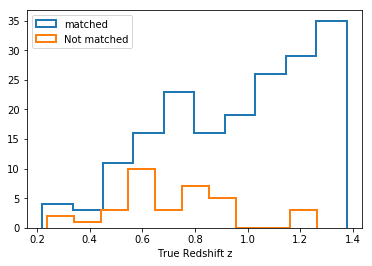

In [259]:
plt.hist(all_sn[all_sn['matched']]['redshift'], histtype='step', lw=2, label='matched')
plt.hist(all_sn[~all_sn['matched']]['redshift'], histtype='step', lw=2, label='Not matched')
plt.legend(loc='upper left')
plt.xlabel('True Redshift z')

The above plot shows that in the matching we found SNe at really high redshifts, which sound too good to be true. Maybe an angular matching is not the best way, and this motivates the future _time-match_ process in the individual lightcurves.

Text(0.5, 0, 'True Redshift z')

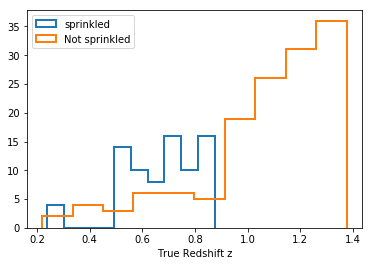

In [260]:
plt.hist(all_sn[all_sn['sprinkled']==1]['redshift'], histtype='step', lw=2, label='sprinkled')
plt.hist(all_sn[all_sn['sprinkled']==0]['redshift'], histtype='step', lw=2, label='Not sprinkled')
plt.legend(loc='upper left')
plt.xlabel('True Redshift z')

The above plot is also unexpected to me. I thought that sprinkled sources are the ones that had higher redshifts. This would need further confirmation (I am not a sprinkled sources expert).

Text(0.5, 0, 'Sprinkled')

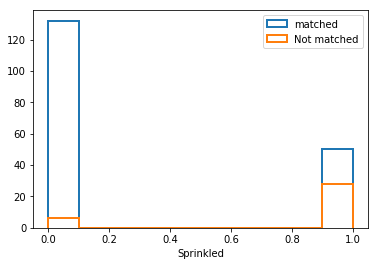

In [261]:
plt.hist(all_sn[all_sn['matched']]['sprinkled'], histtype='step', lw=2, label='matched')
plt.hist(all_sn[~all_sn['matched']]['sprinkled'], histtype='step', lw=2, label='Not matched')
plt.legend(loc='upper right')
plt.xlabel('Sprinkled')

--------
## Asking for the lightcurves

Now we are going to ask for the individual light curves and produce a full catalog of matched/not-matched sources.  
The target catalog should contain a set of columns that include DIA data, as well as SN truth data.  
The whole group of columns will contain information only if we have a match in coordinates as well as in _time_. We are actually finding coincident epochs in the DIA and truth SN lightcurves.  
In the case that we don't find match, a subset of our columns shall have then missing information.

In [262]:
snlc_cols = truth_lc.list_all_quantities(include_native=True)

In [263]:
snlc_cols

['uniqueId', 'obshistid', 'filter', 'mjd', 'mag']

In [264]:
dialc_cols = ['visit', 'mjd', 'psFlux', 'psFluxErr', 'mag', 'mag_err',  'isDipole', 'apFlux',
               'apFluxErr', 'filter', 'ra', 'dec', 'diaObjectId', 'id', 'diaSourceId']

In [265]:
combocols = ['dia_'+col for col in dialc_cols]
combocols.extend(['sn_'+col for col in snlc_cols])

### WARNING

The way this is programmed is favoring readability against performance. I took this direction so the code can be shared.  

For this reason it takes a couple of hours, since it queries every single lightcurve in DIA and SN truth catalogs.  
If you don't have time to wait for this, the table has been saved and after this block cell you can read it. 

In [ ]:
im = 0
log_buffer = ''
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
fullcat['sn_lc_len'] = 0
fullcat['dia_lc_len'] = 0
lc_rows = [combocols]
aminute = 1./(24*60.)
for i, arow in fullcat.iterrows():
    #if im> 5: break
    # what kind of row is this?
    if arow['match'] and arow['sn_matched']:
        #  we have a match in space
        #  asking for the light curves
    
        #first SN
        ff = ['uniqueId == {}'.format(arow["sn_Uid"])]
        sn_lc = truth_lc.get_quantities(snlc_cols, native_filters=ff)
        sn_lc = pd.DataFrame(sn_lc)
        # if length is zero then mark as ??
        snlc_flength = len(sn_lc)
        fullcat.loc[i, 'sn_lc_len'] = snlc_length

        #then DIA
        diaObjectId = arow['diaObjectId']  # get the diaObjectId
        # We can't use a direct filters = match in the GCR wrapper for the diaSrc table.
        # So we have to use a lambda function here to match the ID
        dia_lc = diaSrc.get_quantities(dialc_cols, filters=[(lambda x: x == diaObjectId, 'diaObjectId')])
        dia_lc = pd.DataFrame(dia_lc)
        dia_lc = dia_lc.sort_values('mjd')
        dialc_flength = len(dia_lc)
        fullcat.loc[i, 'dia_lc_len'] = dialc_lenght
        
        # write our pseudo log
        log_buffer += f"""found {snlc_length} points in the truth lightcurve, and found {dialc_lenght} in the DIA \n"""
        
        
        for ifilter, nfilter in enumerate(filter_names):
                        
            dia_lc_filtered = dia_lc[dia_lc['filter']==nfilter]
            sn_lc_filtered = sn_lc[sn_lc['filter']==ifilter]

            dialc_length = len(dia_lc_filtered)
            snlc_length = len(sn_lc_filtered)

            # check existent data in the light curves
            if dialc_length is 0 and snlc_length is 0:
                continue     
            elif dialc_length is 0 and snlc_length is not 0:
                for k_epoch, datarow in sn_lc.iterrows():
                    newcomborow = len(dialc_cols)*[None]
                    newcomborow.extend([datarow[sncol] for sncol in snlc_cols])
                    lc_rows.append(newcomborow)
            elif dialc_length is not 0 and snlc_length is 0:
                for j_epoch, datarow in dia_lc.iterrows():
                    newcomborow = [datarow[diacol] for diacol in dialc_cols]
                    newcomborow.extend(len(snlc_cols)*[None])
                    lc_rows.append(newcomborow)
            else:  # here we do match the catalogs in time
                idxs = []
                for iepoch, sndata in sn_lc_filtered.iterrows():
                    t = sndata['mjd']
                    deltas = np.abs(t-dia_lc_filtered['mjd'])
                    mindt = np.min(deltas)
                    if mindt<=5*aminute:
                        dia_idx = int(np.where(deltas==np.min(deltas))[0][0])
                        idxs.append(dia_idx)
                        dia_datarow = [dia_lc_filtered.iloc[dia_idx][a_col] for a_col in dialc_cols]
                        lc_rows.append(dia_datarow+[sndata[acol] for acol in snlc_cols])
                    else:
                        lc_rows.append(len(dialc_cols)*[None]+[sndata[acol] for acol in snlc_cols])
                # take care of the dia rows not used
                for iepoch, diadata in dia_lc_filtered.iterrows():
                    if iepoch not in idxs:
                        #print(iepoch)
                        dia_datarow = [diadata[a_col] for a_col in dialc_cols]
                        lc_rows.append(dia_datarow+len(snlc_cols)*[None])
        #im+=1
        
    elif not arow['match'] and not arow['sn_matched']:
        log_buffer += 'This combination are orphan objects. \n'
        if arow['diaObjectId'] is not None:
            #then DIA
            diaObjectId = arow['diaObjectId']  # get the diaObjectId
            # We can't use a direct filters = match in the GCR wrapper for the diaSrc table.
            # So we have to use a lambda function here to match the ID
            dia_lc = diaSrc.get_quantities(dialc_cols, filters=[(lambda x: x == diaObjectId, 'diaObjectId')])
            dia_lc = pd.DataFrame(dia_lc)
            dia_lc = dia_lc.sort_values('mjd')
            dialc_flength = len(dia_lc)
            fullcat.loc[i, 'dia_lc_len'] = dialc_lenght
            for j_epoch, datarow in dia_lc.iterrows():
                newcomborow = [datarow[diacol] for diacol in dialc_cols]
                newcomborow.extend(len(snlc_cols)*[None])
                lc_rows.append(newcomborow)
            
        elif arow['snUid'] is not None:
            #first SN
            ff = ['uniqueId == {}'.format(arow["sn_Uid"])]
            sn_lc = truth_lc.get_quantities(snlc_cols, native_filters=ff)
            sn_lc = pd.DataFrame(sn_lc)
            # if length is zero then mark as ??
            snlc_flength = len(sn_lc)
            fullcat.loc[i, 'sn_lc_len'] = snlc_length
            for k_epoch, datarow in sn_lc.iterrows():
                newcomborow = len(dialc_cols)*[None]
                newcomborow.extend([datarow[sncol] for sncol in snlc_cols])
                lc_rows.append(newcomborow)
                
    elif arow['match'] and not arow['sn_matched']:
        print('HALT 3')
        log_buffer += 'This combination should not exist. Will search for DIA LC \n'
    else:
        print('HALT 4')
        log_buffer += 'This combination should not exist. Will search for SN lc'

In [285]:
flc_match = pd.DataFrame(lc_rows[1:], columns=lc_rows[0])

In [286]:
flc_match['filter'] = None

In [287]:
ffd = pd.notnull(flc_match['dia_diaSourceId'])
ffs = pd.notnull(flc_match['sn_uniqueId'])

In [288]:
flc_match.loc[ffd, 'filter'] = flc_match.loc[ffd, 'dia_filter']

In [290]:
flc_match.loc[ffs, 'filter'] = [filter_names[int(fcode)] for fcode in flc_match.loc[ffs, 'sn_filter']]

In [291]:
flc_match.to_csv('flc_match.csv')

In [ ]:
flc_match = pd.read_csv('flc_match.csv')

In [287]:
ffd = pd.notnull(flc_match['dia_diaSourceId'])
ffs = pd.notnull(flc_match['sn_uniqueId'])

In [292]:
found_snepochs = flc_match[ffs&ffd]
lost_snepochs = flc_match[~ffd & ffs]
orphan_depocs = flc_match[ffd & ~ffs]

In [293]:
all_snepochs = flc_match[ffs]

### Inspecting samples
----------

Now we are producing a couple of plots, showing some differences in DIA vs SN truth, using the matched epochs.

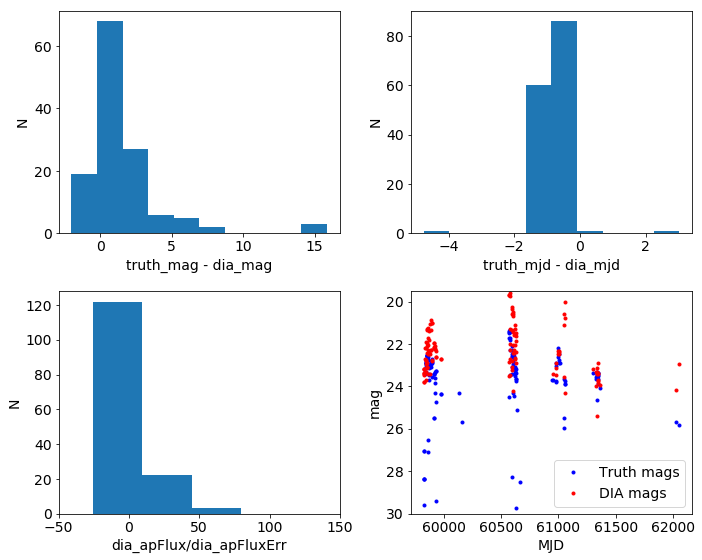

In [355]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(found_snepochs.sn_mag-found_snepochs.dia_mag)
plt.xlabel('truth_mag - dia_mag')
plt.ylabel('N')

plt.subplot(222)
plt.hist((found_snepochs.sn_mjd-found_snepochs.dia_mjd)*24.*60, log=False, bins=10)
plt.xscale('linear')
plt.xlabel('truth_mjd - dia_mjd')
plt.ylabel('N')

plt.subplot(223)
plt.hist(found_snepochs.dia_apFlux/found_snepochs.dia_apFluxErr)
plt.xlim(-50, 150)
plt.xlabel('dia_apFlux/dia_apFluxErr')
plt.ylabel('N')

plt.subplot(224)
plt.plot(found_snepochs.sn_mjd, found_snepochs.sn_mag, 'b.', label='Truth mags')
plt.plot(found_snepochs.dia_mjd, found_snepochs.dia_mag, 'r.', label='DIA mags')
plt.legend(loc='best')
plt.ylim(30, 19.5)
plt.xlabel('MJD')
plt.ylabel('mag')
plt.tight_layout()

In [319]:
found_snepochs.columns

Index(['dia_visit', 'dia_mjd', 'dia_psFlux', 'dia_psFluxErr', 'dia_mag',
       'dia_mag_err', 'dia_isDipole', 'dia_apFlux', 'dia_apFluxErr',
       'dia_filter', 'dia_ra', 'dia_dec', 'dia_diaObjectId', 'dia_id',
       'dia_diaSourceId', 'sn_uniqueId', 'sn_obshistid', 'sn_filter', 'sn_mjd',
       'sn_mag', 'filter'],
      dtype='object')

In [394]:
len(found_snepochs)

149

In [395]:
len(all_snepochs)

31094

### Efficiency graphs
------------

This function goes through the true supernovae and counts how many we have found in magnitude bins.  
This quantity is called the TP, or True Positives.  
We also calculate the False Positives, and the Recall R value, which is the ratio of TP to the total amount of SNe.

In [450]:
def recalls_filter(cat, filter='g', bins=np.arange(21, 26, 0.5)):
    inj = cat[cat['filter']==filter].copy()
    inj = inj.sort_values('sn_mag')
    
    ind = np.digitize(inj['sn_mag'], bins)
    recalls = np.zeros((len(bins), 4))
    for val, group in inj.groupby(ind):
        
        ibin = val-1
        fn = np.sum(pd.notnull(group['sn_uniqueId']))
        tp = np.sum(pd.notnull(group['dia_diaObjectId']))
    
        tot = len(group)
        recall = tp/(tp+fn)
        recalls[ibin, :] = tp, fn, recall, tot
    
    return(recalls)

In [452]:
bins = np.arange(18, 40, .5)
recalls_g = recalls_filter(all_snepochs, filter='g', bins=bins)
recalls_r = recalls_filter(all_snepochs, filter='r', bins=bins)
recalls_i = recalls_filter(all_snepochs, filter='i', bins=bins)
recalls_z = recalls_filter(all_snepochs, filter='z', bins=bins)
recalls_y = recalls_filter(all_snepochs, filter='y', bins=bins)

In [453]:
print(np.sum(recalls_g, axis=0))
print(np.sum(recalls_r, axis=0))
print(np.sum(recalls_i, axis=0))
print(np.sum(recalls_z, axis=0))
print(np.sum(recalls_y, axis=0))

[9.00000000e+00 4.43700000e+03 1.03503401e+00 4.43700000e+03]
[2.2000000e+01 5.6160000e+03 5.5698013e-01 5.6160000e+03]
[4.20000000e+01 5.31500000e+03 5.74711474e-01 5.31500000e+03]
[2.40000000e+01 5.88400000e+03 3.77025405e-01 5.88400000e+03]
[5.20000000e+01 5.76000000e+03 5.85011023e-01 5.76000000e+03]


Text(0, 0.5, 'recall R')

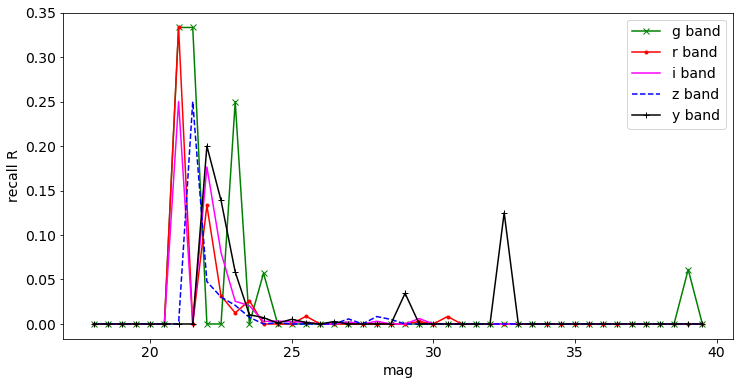

In [454]:
plt.figure(figsize=(12, 6))
plt.plot(bins, recalls_g[:, 2], 'x-', color='green', label='g band')
plt.plot(bins, recalls_r[:, 2], '.-', color='red', label='r band')
plt.plot(bins, recalls_i[:, 2], '-', color='magenta', label='i band')
plt.plot(bins, recalls_z[:, 2], '--', color='blue', label='z band')
plt.plot(bins, recalls_y[:, 2], '+-', color='black', label='y band')
plt.legend(loc='best')
plt.xlabel('mag')
plt.ylabel('recall R')

Text(0, 0.5, 'True positives TP')

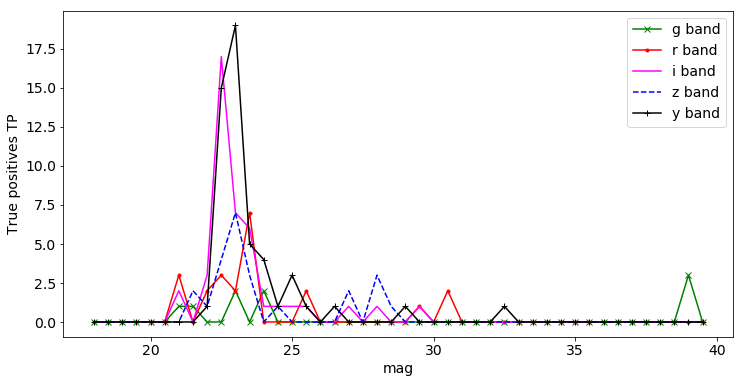

In [455]:
plt.figure(figsize=(12, 6))
plt.plot(bins, recalls_g[:, 0], 'x-', color='green', label='g band')
plt.plot(bins, recalls_r[:, 0], '.-', color='red', label='r band')
plt.plot(bins, recalls_i[:, 0], '-', color='magenta', label='i band')
plt.plot(bins, recalls_z[:, 0], '--', color='blue', label='z band')
plt.plot(bins, recalls_y[:, 0], '+-', color='black', label='y band')
plt.legend(loc='best')
plt.xlabel('mag')
plt.ylabel('True positives TP')
#plt.yscale('log')

Text(0, 0.5, 'False Negatives FN')

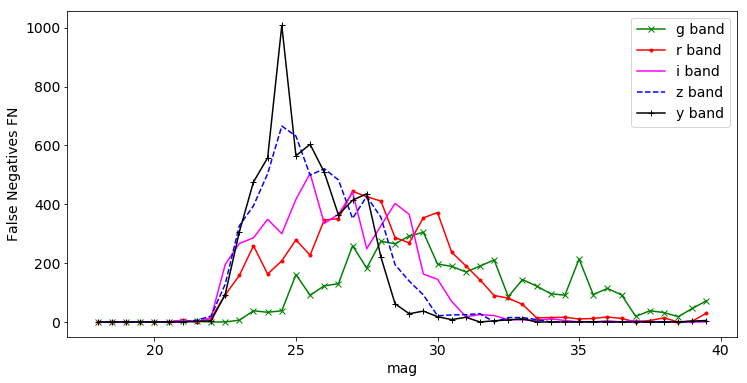

In [456]:
plt.figure(figsize=(12, 6))
plt.plot(bins, recalls_g[:, 1], 'x-', color='green', label='g band')
plt.plot(bins, recalls_r[:, 1], '.-', color='red', label='r band')
plt.plot(bins, recalls_i[:, 1], '-', color='magenta', label='i band')
plt.plot(bins, recalls_z[:, 1], '--', color='blue', label='z band')
plt.plot(bins, recalls_y[:, 1], '+-', color='black', label='y band')
plt.legend(loc='best')
plt.xlabel('mag')
plt.ylabel('False Negatives FN')
#plt.yscale('log')

### New graphs

Rahul B. asked for some more graphs on the results of this

First one is to build the figure of the distribution of brightness for the total amount of objects.  
Secondly we have the recall for the first bins.

In [458]:
#plt.rcParams()
plt.rcParams.update({'font.size': 14})

(16, 34)

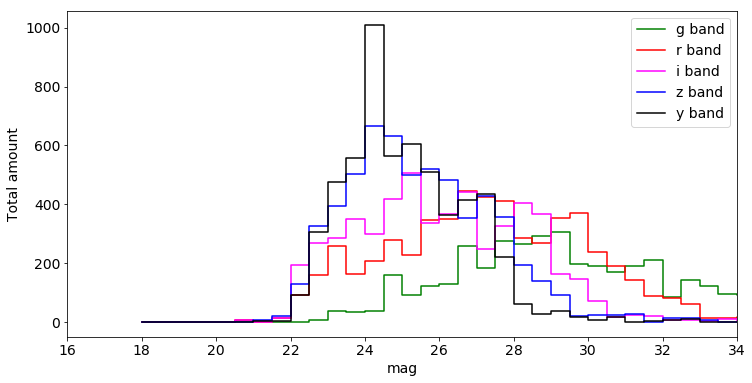

In [457]:
plt.figure(figsize=(12, 6))
plt.step(bins, recalls_g[:, 3], #'x-', 
         color='green', label='g band')
plt.step(bins, recalls_r[:, 3], #'.-',
         color='red', label='r band')
plt.step(bins, recalls_i[:, 3], #'-', 
         color='magenta', label='i band')
plt.step(bins, recalls_z[:, 3], #'--',
         color='blue', label='z band')
plt.step(bins, recalls_y[:, 3], #'+-',
         color='black', label='y band')
plt.legend(loc='best')
plt.xlabel('mag')
plt.ylabel('Total amount')
#plt.yscale('log')
plt.xlim(16, 34)

(16, 28)

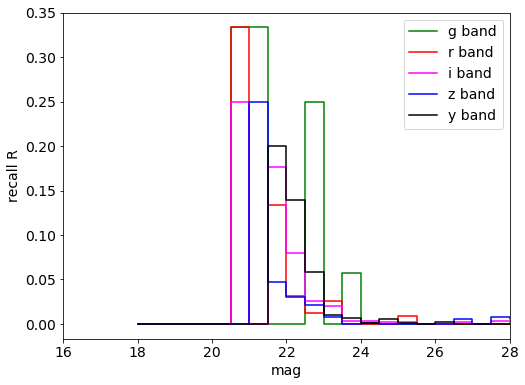

In [459]:
plt.figure(figsize=(8, 6))
plt.step(bins, recalls_g[:, 2], #'x-',
         color='green', label='g band')
plt.step(bins, recalls_r[:, 2], #'.-',
         color='red', label='r band')
plt.step(bins, recalls_i[:, 2], #'-', 
         color='magenta', label='i band')
plt.step(bins, recalls_z[:, 2], #'--',
         color='blue', label='z band')
plt.step(bins, recalls_y[:, 2], #'+-',
         color='black', label='y band')
plt.legend(loc='best')
plt.xlabel('mag')
plt.ylabel('recall R')
plt.xlim(16, 28)

----------------

In [460]:
for a in enumerate(filter_names):
    print(a)

(0, 'u')
(1, 'g')
(2, 'r')
(3, 'i')
(4, 'z')
(5, 'y')


In [314]:
#print(log_buffer)